In [1]:
%matplotlib inline

import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size':16})

import sciunit
from owtests import OW_HOME
import wcon
import open_worm_analysis_toolbox as owat

In [2]:
# The location of OWAT validation tests, not of the OWAT package itself
OWAT_TESTS = os.path.join(OW_HOME,'tests','owtests','open-worm-analysis-toolbox')

### Compute features from a Schafer-style experiment data file

In [3]:
def get_schafer_features(file):
    # Load a "basic" worm from a file
    path = os.path.join(OW_HOME,'open-worm-analysis-toolbox','example_data',file)
    bw = owat.BasicWorm.from_schafer_file_factory(path)
    # Normalize the basic worm
    nw = owat.NormalizedWorm.from_BasicWorm_factory(bw)
    # Compute the features
    wf_experiment_schafer = owat.WormFeatures(nw)
    return wf_experiment_schafer

In [4]:
%time wf_experiment_schafer_1 = get_schafer_features('example_contour_and_skeleton_info.mat')

CPU times: user 35.7 s, sys: 475 ms, total: 36.2 s
Wall time: 36.2 s


### Compute features from a WCON-style experiment data file

In [5]:
# A function to convert the WCON skeleton data into the format required for owat.BasicWorm 
def basic_worm_from_wcon(wcon_data):
    bw = owat.BasicWorm()
    data = wcon_data.data
    worm_name = data.columns.levels[0][0]
    skeleton_data = [data[worm_name].iloc[frame].unstack().iloc[1:].values for frame in range(data.shape[0])]
    if skeleton_data[0].shape[0]==4:
        skeleton_data = [x[2:,:] for x in skeleton_data]
    skeleton_data = [x.astype('float') for x in skeleton_data]
    bw._h_skeleton = skeleton_data
    return bw

In [6]:
# A function to get an OWAT features object from a WCON
def get_wcon_features(file):
    path = os.path.join(OWAT_TESTS,file)
    data = wcon.WCONWorms.load_from_file(path)
    bw = basic_worm_from_wcon(data)
    nw = owat.NormalizedWorm.from_BasicWorm_factory(bw)
    wf = owat.WormFeatures(nw)
    return wf

In [7]:
file = 'experiment/nca-1 (gk9) nca-2 (gk5) nRHO-1 QT309 on food L_2011_11_09__12_02___3___6.wcon'
%time wf_experiment_wcon = get_wcon_features(file)

Loading file: /Users/rgerkin/dev/openworm/tests/owtests/open-worm-analysis-toolbox/experiment/nca-1 (gk9) nca-2 (gk5) nRHO-1 QT309 on food L_2011_11_09__12_02___3___6.wcon
CPU times: user 3min 35s, sys: 56.2 s, total: 4min 31s
Wall time: 4min 32s


### Compute features from a WCON-style model data file

In [8]:
file = 'model/worm_motion_log.wcon'
%time wf_model_wcon = get_wcon_features(file)

Loading file: /Users/rgerkin/dev/openworm/tests/owtests/open-worm-analysis-toolbox/model/worm_motion_log.wcon
CPU times: user 2min 58s, sys: 1.67 s, total: 3min
Wall time: 3min


### Fill a data frame with feature means for these three kinds of files

In [9]:
# Get a list of all the possible features
features = list(wf_experiment_schafer_1._features.keys())
# Make a data frame to store feature means
df = pd.DataFrame(index=features,columns=['wcon_model','wcon_experiment','schafer_experiment'])

# A function to fill the data frame with the feature means
def fill_df(wf,df,column):
    n_valid = 0
    for feature,value in wf._features.items():
        try: # Fill with feature means only if the feature is found and has some numeric data
            result = pd.Series(value.value).mean()
            if not np.isnan(result):
                df.loc[feature,column] = result
                n_valid += 1
        except:
            pass
    # Valid features are the ones that were computed and have some numeric data
    print("%d valid features found for %s" % (n_valid,column))
    return df.astype('float')
    
# Populate the data frame with mean features from:
# the model (from WCON)
df = fill_df(wf_model_wcon,df,'wcon_model')
# an experiment (from WCON)
df = fill_df(wf_experiment_wcon,df,'wcon_experiment')
# and another experiment (from Schafer)
df = fill_df(wf_experiment_schafer_1,df,'schafer_experiment')
df.head()

48 valid features found for wcon_model
83 valid features found for wcon_experiment
81 valid features found for schafer_experiment


,wcon_model,wcon_experiment,schafer_experiment
morphology.length,1.163448,1021.864316,966.907818
morphology.width.head,NaN,NaN,47.097449
morphology.width.midbody,NaN,NaN,85.879552
morphology.width.tail,NaN,NaN,47.009043
morphology.area,NaN,NaN,70229.892541


### Plot mean features derived from a WCON experiment file and a Schafer experiment file (these are two different experiments) against each other

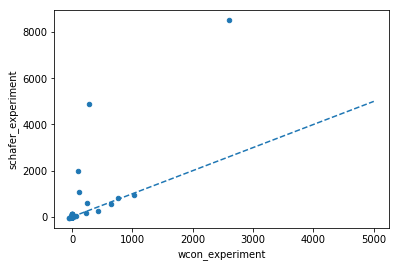

In [10]:
# Note that there is some correlation (some points near the unity line)
df.plot.scatter(x='wcon_experiment',y='schafer_experiment')
plt.plot([0,5000],[0,5000],'--')

### Plot mean features derived from a WCON experiment file and a WCON model file against each other

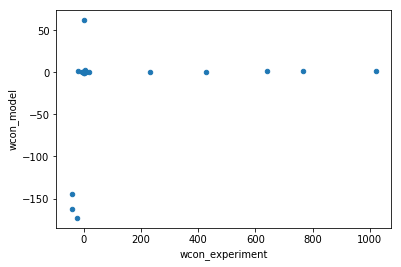

In [11]:
# These don't seem to have any correlation with one another
df.plot.scatter(x='wcon_experiment',y='wcon_model')

In [12]:
# Some features (at least this one, which is easy to get from the skeleton)
# appear to at least be on the same scale
feature_name = 'posture.amplitude_ratio'
model_mean = pd.Series(wf_model_wcon.get_features(feature_name).value).mean()
experiment_mean = pd.Series(wf_experiment_schafer_1.get_features(feature_name).value).mean()
print(model_mean,experiment_mean)

0.5047637256663084 0.7644687430799605


### Compute the Spearman correlation to at least see if features with large means in the model are the ones with large means in the experiment (and similarly for small means)

In [13]:
df.corr(method='spearman')

,wcon_model,wcon_experiment,schafer_experiment
wcon_model,1.000000,0.532515,0.490939
wcon_experiment,0.532515,1.000000,0.646610
schafer_experiment,0.490939,0.646610,1.000000


### Overall, the correlations are modest.  Importantly, the correlation between model and experiment isn't really that much worse than the correlation between two experiments (using two different input file formats)